# 2021-11-18 • Prototype new sim

One numba-optimised function doing synaptic integration and izhikevich sim.

To allow simulations with many neurons / input spike trains to fit in memory, we do not save all signals, only "recorded" ones (as the simulators like Brian do).

## Prelude

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga` on **Mon 03 Jan** 2022, at 16:18 (UTC+0100).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/eb3893fc2fd249dfff6f442c0144906c0e8ea417
) (Thu 09 Dec 2021, 11:06).
Uncommited changes to 3 files.

## Parameters

In [112]:
dt = 0.1 * ms
duration = 10 * second

N = 4  # number of neurons

τ_syn = 7 * ms
injected_noise_σ = 3 * mV

v_r    = -60 * mV
v_t    = -40 * mV
v_peak =  35 * mV
c      = -50 * mV  # aka v_reset

C = 100 * pF
k = 0.7 * (nS/mV)
b = -2 * nS
a = 0.03 / ms
d = 100 * pA;

In [88]:
v_syn = np.array([0*mV, 0*mV, 0*mV, -65*mV]);
# This is the postsynaptic reversal potential for all this neuron's output connections

In [110]:
ge = 4 * nS
gi = 16 * nS
Δg = np.array([
    [0, ge,  0,  0],
    [0,  0,  0,  0],
    [0, ge,  0,  0],
    [0,  0,  0,  0],
]);  # [from, to]

In [100]:
recorded_neurons = [0, 2];

## Sim

In [6]:
num_timesteps = v.sim.izhikevich_neuron.to_num_timesteps(duration, dt)

100000

In [77]:
from numpy import zeros, ones, newaxis
from numpy.random import randn

In [ ]:
v_record = np.empty((num_timesteps, len(recorded_neurons)))

recorded_neurons = np.array(recorded_neurons)
# The type of this iterable may not be `tuple`. (Because we want to use it to select multiple elements.
# See the last example here: https://numpy.org/doc/stable/user/basics.indexing.html)

v_syn.shape = (N, 1)
# Transform into column vector, to make the subtraction (v_syn - v) below
# generate a matrix, via broadcasting.

v = ones(N) * v_r
u = zeros(N)
g = zeros((N, N))

spikes = tuple([[] * N])

for i in range(num_timesteps):

    # Synaptic conductance & current
    g -= g / τ_syn * dt
    I_syn = g * (v_syn - v)
    I_syn_total = np.sum(I_syn, axis=0)
    
    # todo: make stochastic differential,
    # https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html#stochastic-neurons
    I_noise = randn(N) * injected_noise_σ

    # Izhikevich neuron
    v += (k * (v - v_r) * (v - v_t) - u + I_syn_total + I_noise) / C * dt
    u += a * (b * (v - v_r) - u) * dt
    has_spiked = v >= v_peak
    v[has_spiked] = c
    u[has_spiked] += d
    
    # Conductance bumps. The non-spiking rows are zeroed by the multiplication.
    # (Hence the transformation of `has_spiked` into a column vector: for broadcasting).
    g += Δg * has_spiked[:, newaxis]
    
    # Record spike times
    for j in v.indices_where(has_spiked):
        spikes[j].append(i)
    
    # Record selected signals
    v_record[i, :] = v[recorded_neurons]
    
    # For spikers, retroactively set previous timestep's v to v_peak.
    # Goal: consistent spike height.
    v_record[i-1, has_spiked[recorded_neurons]] = v_peak


Current direction is how positive charges move. Ergo positive current = $v_m$ increase (depolarisation).

## On discretizing the voltage reset

"We're basically choosing between a slightly too sharp and early peak, and a slightly too late and flat-topped one."

In [14]:
from voltage_to_wiring_sim.experiments.N_to_1_IE import Params, simulate_and_test_connections
from dataclasses import replace
base_params = Params()
sim_and_test = v.cache_to_disk(simulate_and_test_connections)
d, td, ts = sim_and_test(base_params)

________________________________________________________________________________
[Memory] Calling voltage_to_wiring_sim.experiments.N_to_1_IE.simulate_and_test_connections...
simulate_and_test_connections(Params(sim_duration=600, timestep=0.0001, τ_syn=0.007, neuron_params=IzhikevichParams(C=1e-10, k=7e-07, v_r=-0.06, v_t=-0.04, v_peak=0.035, a=30.0, b=-2e-09, c=-0.05, d=1e-10), imaging_spike_SNR=20, window_duration=0.1, num_spike_trains=30, p_inhibitory=0.2, p_connected=0.7, spike_rate=20.0, Δg_syn_exc=4.0000000000000007e-10, Δg_syn_inh=1.6000000000000003e-09, v_syn_exc=0.0, v_syn_inh=-0.065, rng_seed=0))
30/30
___________________________________simulate_and_test_connections - 26.4s, 0.4min


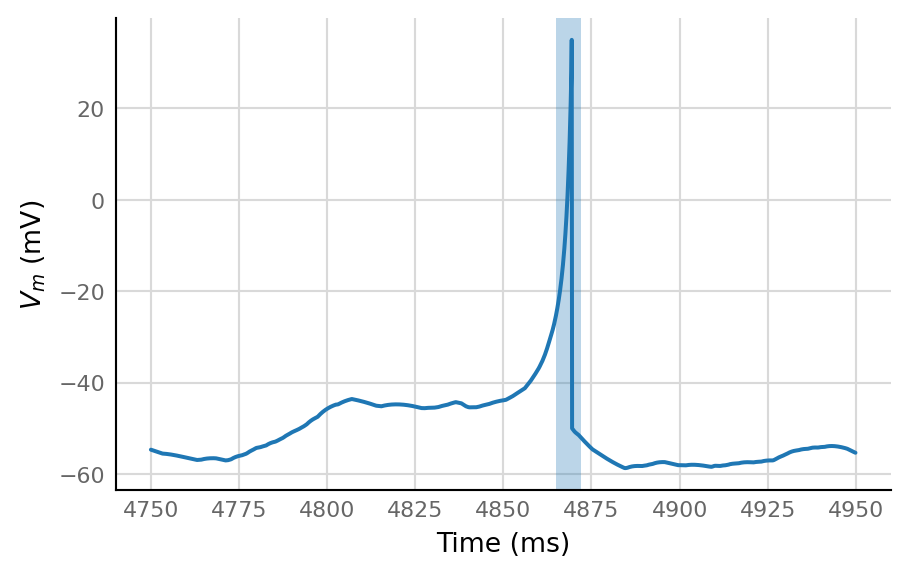

In [74]:
ax = v.plot_signal(d.izh_output.V_m.slice(4.75, 0.2) / mV, time_units=ms)
zoom_start = 4865 * ms
zoom_duration = 7 * ms
ax.axvspan(zoom_start / ms, (zoom_start + zoom_duration) / ms, alpha=0.3);
ax.set(xlabel="Time (ms)", ylabel="$V_m$ (mV)");

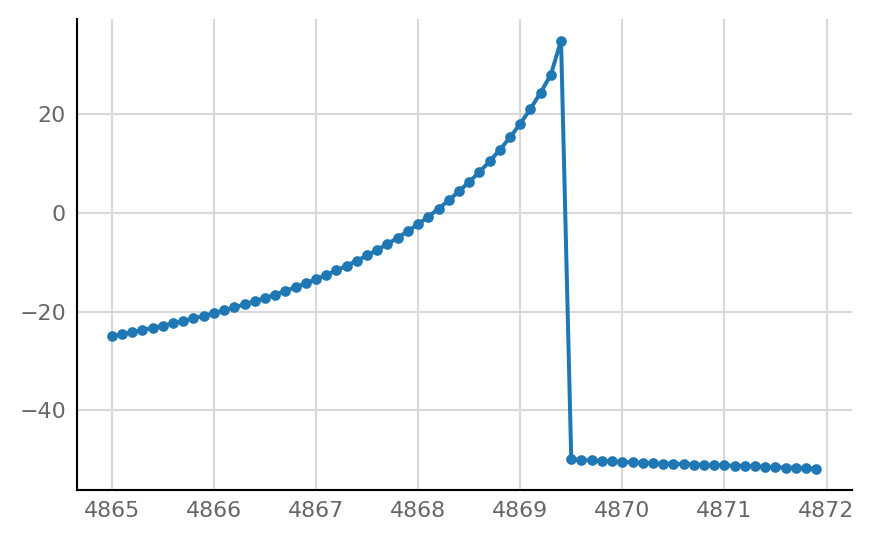

In [75]:
v.plot_signal(d.izh_output.V_m.slice(zoom_start, zoom_duration) / mV, time_units=ms, marker="o", ms=3);

## Reproducibility

In [5]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `lpxtf3` on `DUIP74576`<br>on **Thu 18 Nov** 2021, at 23:21 (UTC+0000).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/6034551337c7993a872386a1e0f0278f87fa57e9
) (Thu 18 Nov 2021, 17:05).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/experiments/N_to_1_IE.py
 M notebooks/2021-11-11__vary_both_inh_strength_and_proportion.ipynb
?? notebooks/2021-11-18__constant_input_spikes-Copy1.ipynb
?? notebooks/2021-11-18__constant_input_spikes.ipynb
```

Platform:

Windows-10
CPython 3.9.6 (C:\miniforge3\python.exe)
Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.21.1
matplotlib           3.4.2
numba                0.53.1
joblib               1.0.1
seaborn              0.11.1
scipy                1.7.0
preload              2.2
nptyping             1.4.2


Full conda list:

```
# packages in environment at C:\miniforge3:
#
# Name                    Version                   Build  Channel
argon2-cffi               20.1.0           py39hb82d6ee_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
black                     21.9b0             pyhd8ed1ab_1    conda-forge
bleach                    3.3.1              pyhd8ed1ab_0    conda-forge
brotlipy                  0.7.0           py39hb82d6ee_1001    conda-forge
ca-certificates           2021.10.8            h5b45459_0    conda-forge
certifi                   2021.10.8        py39hcbf5309_1    conda-forge
cffi                      1.14.6           py39h0878f49_0    conda-forge
chardet                   4.0.0            py39hcbf5309_1    conda-forge
charset-normalizer        2.0.0              pyhd8ed1ab_0    conda-forge
click                     7.1.2                    pypi_0    pypi
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
colorful                  0.5.4                    pypi_0    pypi
conda                     4.10.3           py39hcbf5309_2    conda-forge
conda-package-handling    1.7.3            py39hb3671d1_0    conda-forge
cryptography              3.4.7            py39hd8d06c1_0    conda-forge
cycler                    0.10.0                   pypi_0    pypi
dataclasses               0.8                pyhc8e2a94_3    conda-forge
debugpy                   1.4.1            py39h415ef7b_0    conda-forge
decorator                 5.0.9              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
icu                       68.2                 h0e60522_0    conda-forge
idna                      3.1                pyhd3deb0d_0    conda-forge
importlib-metadata        4.6.1            py39hcbf5309_0    conda-forge
ipykernel                 6.0.3            py39h832f523_0    conda-forge
ipython                   7.25.0           py39h832f523_1    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
jedi                      0.18.0           py39hcbf5309_2    conda-forge
jinja2                    3.0.1              pyhd8ed1ab_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
jsonschema                3.2.0              pyhd8ed1ab_3    conda-forge
jupyter_client            6.1.12             pyhd8ed1ab_0    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1              pyhd8ed1ab_2    conda-forge
jupyter_core              4.7.1            py39hcbf5309_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py39hcbf5309_1002    conda-forge
jupyter_latex_envs        1.4.6           pyhd8ed1ab_1002    conda-forge
jupyter_nbextensions_configurator 0.4.1            py39hcbf5309_2    conda-forge
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
kiwisolver                1.3.1                    pypi_0    pypi
libclang                  11.1.0          default_h5c34c98_1    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libxml2                   2.9.12               hf5bbc77_0    conda-forge
libxslt                   1.1.33               h65864e5_2    conda-forge
libzlib                   1.2.11            h8ffe710_1013    conda-forge
llvmlite                  0.36.0                   pypi_0    pypi
lxml                      4.6.3            py39h4fd7cdf_0    conda-forge
markupsafe                2.0.1            py39hb82d6ee_0    conda-forge
matplotlib                3.4.2                    pypi_0    pypi
matplotlib-inline         0.1.2              pyhd8ed1ab_2    conda-forge
menuinst                  1.4.17           py39hcbf5309_1    conda-forge
miniforge_console_shortcut 2.0                  h57928b3_0    conda-forge
mistune                   0.8.4           py39hb82d6ee_1004    conda-forge
mypy_extensions           0.4.3            py39hcbf5309_4    conda-forge
nbclient                  0.5.3              pyhd8ed1ab_0    conda-forge
nbconvert                 6.1.0            py39hcbf5309_0    conda-forge
nbformat                  5.1.3              pyhd8ed1ab_0    conda-forge
nest-asyncio              1.5.1              pyhd8ed1ab_0    conda-forge
notebook                  6.4.0              pyha770c72_0    conda-forge
nptyping                  1.4.2                    pypi_0    pypi
numba                     0.53.1                   pypi_0    pypi
numpy                     1.21.1                   pypi_0    pypi
openssl                   1.1.1l               h8ffe710_0    conda-forge
packaging                 21.0               pyhd8ed1ab_0    conda-forge
pandas                    1.3.1                    pypi_0    pypi
pandoc                    2.14.1               h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.8.2              pyhd8ed1ab_0    conda-forge
pathspec                  0.9.0              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.3.1                    pypi_0    pypi
pip                       21.2.1             pyhd8ed1ab_0    conda-forge
platformdirs              2.3.0              pyhd8ed1ab_0    conda-forge
preload                   2.2                      pypi_0    pypi
prettyprinter             0.18.0                   pypi_0    pypi
prometheus_client         0.11.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.19             pyha770c72_0    conda-forge
pycosat                   0.6.3           py39hb82d6ee_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.9.0              pyhd8ed1ab_0    conda-forge
pympler                   0.9                      pypi_0    pypi
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py39hcbf5309_7    conda-forge
pyqt-impl                 5.12.3           py39h415ef7b_7    conda-forge
pyqt5-sip                 4.19.18          py39h415ef7b_7    conda-forge
pyqtchart                 5.12             py39h415ef7b_7    conda-forge
pyqtwebengine             5.12.1           py39h415ef7b_7    conda-forge
pyrsistent                0.17.3           py39hb82d6ee_2    conda-forge
pysocks                   1.7.1            py39hcbf5309_3    conda-forge
python                    3.9.6           h7840368_1_cpython    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python_abi                3.9                      2_cp39    conda-forge
pytz                      2021.1                   pypi_0    pypi
pywin32                   300              py39hb82d6ee_0    conda-forge
pywinpty                  1.1.3            py39h99910a6_0    conda-forge
pyyaml                    6.0              py39hb82d6ee_0    conda-forge
pyzmq                     22.1.0           py39he46f08e_0    conda-forge
qt                        5.12.9               h5909a2a_4    conda-forge
regex                     2021.10.23       py39hb82d6ee_1    conda-forge
requests                  2.26.0             pyhd8ed1ab_0    conda-forge
ruamel_yaml               0.15.80         py39hb82d6ee_1004    conda-forge
scipy                     1.7.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi
send2trash                1.7.1              pyhd8ed1ab_0    conda-forge
setuptools                49.6.0           py39hcbf5309_3    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
sqlite                    3.36.0               h8ffe710_0    conda-forge
terminado                 0.10.1           py39hcbf5309_0    conda-forge
testpath                  0.5.0              pyhd8ed1ab_0    conda-forge
tomli                     1.2.2              pyhd8ed1ab_0    conda-forge
tornado                   6.1              py39hb82d6ee_1    conda-forge
tqdm                      4.61.2             pyhd8ed1ab_1    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
typed-ast                 1.4.3            py39hb82d6ee_1    conda-forge
typing_extensions         3.10.0.2           pyha770c72_0    conda-forge
typish                    1.9.2                    pypi_0    pypi
tzdata                    2021a                he74cb21_1    conda-forge
ucrt                      10.0.20348.0         h57928b3_0    conda-forge
urllib3                   1.26.6             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_5    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.29.30037          h902a5da_5    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
win_inet_pton             1.1.0            py39hcbf5309_2    conda-forge
wincertstore              0.2             py39hcbf5309_1006    conda-forge
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
yaml                      0.2.5                he774522_0    conda-forge
zeromq                    4.3.4                h0e60522_0    conda-forge
zipp                      3.5.0              pyhd8ed1ab_0    conda-forge
zlib                      1.2.11            h8ffe710_1013    conda-forge
```